In [2]:
%matplotlib inline
from matplotlib import style
import sys
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
### Precipitation Analysis
from sqlalchemy import inspect
inspector = inspect(engine)

for table_name in inspector.get_table_names():
   for column in inspector.get_columns(table_name):
       print("Table: %s" % table_name, " - Column: %s" % column['name'], " - Type: %s" % column['type'])

Table: measurement  - Column: id  - Type: INTEGER
Table: measurement  - Column: station  - Type: TEXT
Table: measurement  - Column: date  - Type: TEXT
Table: measurement  - Column: prcp  - Type: FLOAT
Table: measurement  - Column: tobs  - Type: FLOAT
Table: station  - Column: id  - Type: INTEGER
Table: station  - Column: station  - Type: TEXT
Table: station  - Column: name  - Type: TEXT
Table: station  - Column: latitude  - Type: FLOAT
Table: station  - Column: longitude  - Type: FLOAT
Table: station  - Column: elevation  - Type: FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data. Show Last Day of Dates
last_day= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day

('2017-08-23')

In [15]:
#* Design a query to retrieve the last 12 months of precipitation data. Select only the `date` and `prcp` values.
rain_days = session.query(Measurement.date,Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').\
                    order_by(Measurement.date.desc()).all()

my_rain = pd.DataFrame(rain_days, columns=['Date','Precipitation']).set_index('Date').sort_values(['Date'], ascending=True)
my_rain=my_rain.dropna(how='all')

my_rain

,Precipitation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,0.02
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


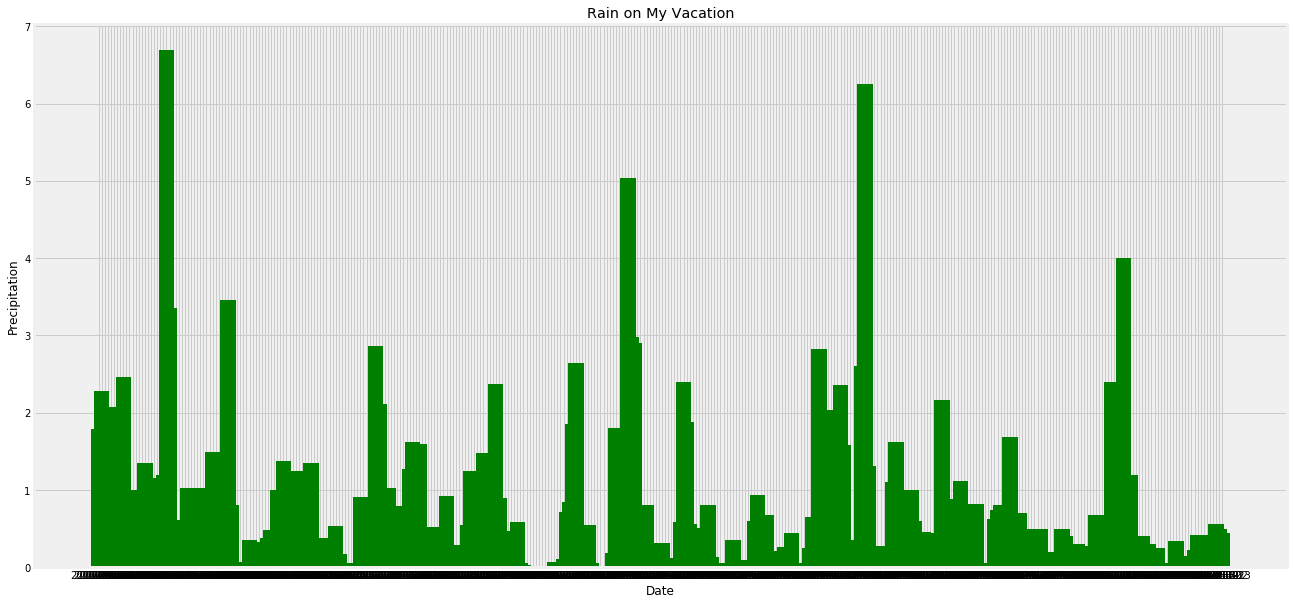

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(20,10))

x=my_rain.index.tolist()
y=my_rain["Precipitation"].tolist()

#Create Bar Graph and bar sizes
width = [5]
plt.bar(x,y,color = 'green',width=width)
xlabels = 'Date'
# Add title and axis names
plt.title('Rain on My Vacation')
plt.xlabel(xlabels)
plt.ylabel('Precipitation')
 
# Show graphic
plt.show()

In [17]:
#Use Pandas to print the summary statistics for the precipitation data
my_rain.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to calculate the total number of stations
session.query(func.count(Station.id)).all()

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list=session.query(Station.station, func.count(Station.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()

station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

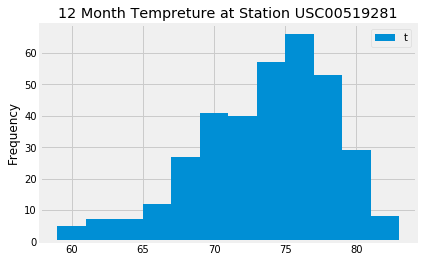

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
rain_by_st = session.query(Measurement.tobs).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').\
                    filter(Measurement.station == 'USC00519281').\
                    order_by(Measurement.date.desc()).all()
st_df=pd.DataFrame(rain_by_st, columns=['tobs'])

st_df['tobs'].hist(bins=12)
plt.title(f"12 Month Tempreture at Station USC00519281")
plt.ylabel('Frequency')
plt.legend('tobs')

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start='2016-12-15'
vacation_end='2016-12-27'
vacation_temp = calc_temps(vacation_start,vacation_end)
print(f"My Vacation Plan is Between: {vacation_start} and {vacation_end}")
print(f"Tempreature Measurements Prior Year to Vacation Days is Expected to be = Min/Avg/Max: {calc_temps(vacation_start,vacation_end)}")

My Vacation Plan is Between: 2016-12-15 and 2016-12-27
Tempreature Measurements Prior Year to Vacation Days is Expected to be = Min/Avg/Max: [(60.0, 71.75903614457832, 78.0)]


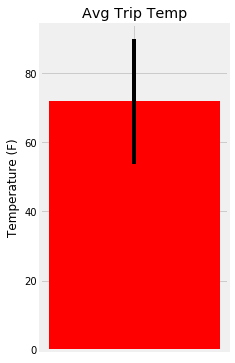

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(3,6))                                                    
plt.bar(1, vacation_temp[0][1], yerr=(vacation_temp[0][2] - vacation_temp[0][0]), tick_label='', color='red')
plt.ylabel("Temperature (F)")
plt.title("Avg Trip Temp" )
plt.show()


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
vac_st = [Measurement.station,\
                Station.name,\
                Station.latitude,\
                Station.longitude,\
                Station.elevation,\
                func.sum(Measurement.prcp)]

vacation_rain= session.query(*vac_st).\
                filter(Measurement.station == Station.station).\
                group_by(Measurement.station).\
                filter(Measurement.date >=vacation_start).\
                filter(Measurement.date >=vacation_end).\
                order_by(func.sum(Measurement.prcp).desc()).all()

vaction = pd.DataFrame(vacation_rain, columns = ['Station Number','Station Name',\
                                                 'Latitude', 'Longitude', 'Elevation',\
                                                 'Cumulative Rainfall'])

vaction

,Station Number,Station Name,Latitude,Longitude,Elevation,Cumulative Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,73.36
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,44.86
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,35.75
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,27.50
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,23.04
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,10.85
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.39


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


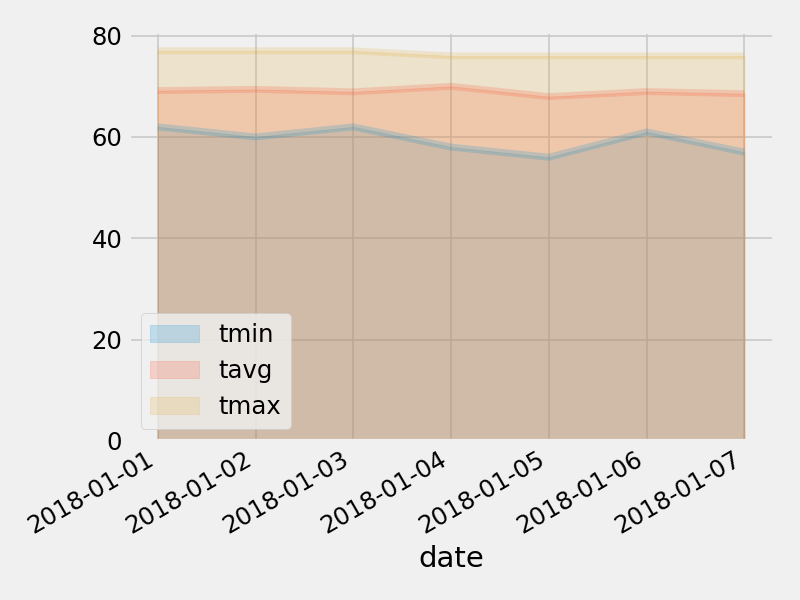

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
